## Бутстрап

Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('hw_bootstrap.csv', sep=';')
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [5]:
df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [6]:
df.value = df.value.str.replace(',','.')
df = df.astype({'value': 'float'})    #тип данных в value из object в float

In [7]:
control = df[df.experimentVariant == 'Control'].value
treat = df[df.experimentVariant == 'Treatment'].value

Распределение значений для контрольной группы:

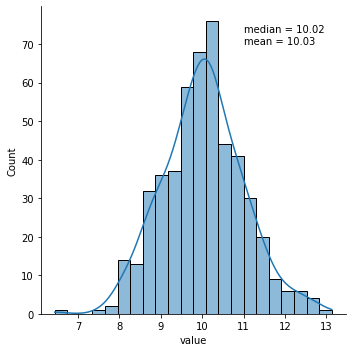

In [8]:
sns.displot(data=control, kde=True)
plt.text(x=11,
         y=70,
         s=f'median = {round(control.median(),2)}\nmean = {round(control.mean(),2)}');

Распределение значений для тестовой группы:

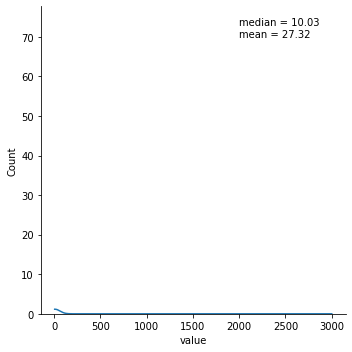

In [9]:
sns.displot(data=treat, kde=True)
plt.text(x=2000,
         y=70,
         s=f'median = {round(treat.median(),2)}\nmean = {round(treat.mean(),2)}',
         fontdict=dict(color='black',size=10));

Значения медиан двух распределений близки, а средние отличаются значительно. Распределение для тестовой группы сильно скошено вправо (есть значения порядка 1000-3000).

In [10]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len,replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.show()
       
    return {'boot_data': boot_data, 
            'ci': ci, 
            'p_value': p_value}

Результаты применения бутстрапа для средних значений:

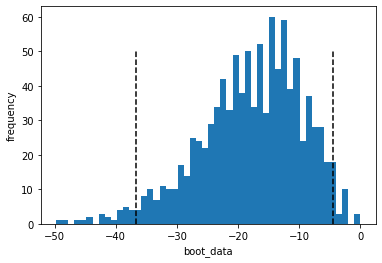

In [11]:
booted_data_mean = get_bootstrap(control, treat)

In [12]:
booted_data_mean['p_value']

0.034812190899169156

In [13]:
booted_data_mean['ci']

,0
0.025,-36.647517
0.975,-4.354138


Ноль не попадает в доверительный интервал, значит есть основания отклонить нулевую гипотезу о равенстве средних в двух группах.

Результаты применения u-теста:

In [14]:
mannwhitneyu(control,treat)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

Уровень значимости p > 0.05, значит, в отличии от результатов бутстрапа, оснований отклонить нулевую гипотезу нет.

Результаты применения бутстрапа для медианных значений:

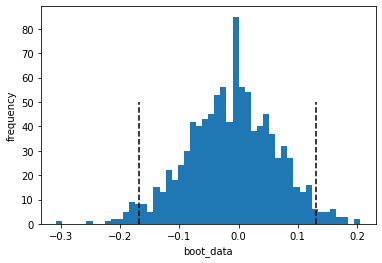

In [15]:
booted_data_median = get_bootstrap(control, treat, statistic = np.median)

In [16]:
booted_data_median['p_value']

0.8760589111877307

In [17]:
booted_data_median['ci']

,0
0.025,-0.168700
0.975,0.130839


Ноль попадает в доверительный интервал, оснований для отклонения нулевой гипотезы о равенстве медиан в двух группах нет.

## Вывод

- В выборке присутствуют выбросы, которые сильно отклоняют среднее значение;

- При применении бутстрапа с оценкой среднего и критерия Манна-Уитни есть основания отклонить нулевую гипотезу в обоих случаях и сделать вывод, что тестовая и контрольная группы имеют различия;

- При применении бутстрапа с оценкой медианы оснований отклонить нулевую гипотезу нет (p-value сильно больше 0.05), потому что проверяется гипотеза о равенстве медиан в двух группах.
